# Forecasting the Realized Volatiliy
Realized volatility is a financial term used to describe the actual level of volatility experienced by a financial asset over a specific period of time. Volatility is a measure of the degree of variation in the price of an asset over time. Realized volatility is calculated by measuring the variation of an asset's price over a set period, which can range from daily to intra-day.

In options trading, the volatility of the underlying asset is a key factor in determining the price of an option. A more accurate prediction of realized volatility can lead to more informed investment decisions.

To predict realized volatility, the ARCH model variations and deep learning models such as LSTM (Long Short-Term Memory), RNN (Recurrent Neural Network), and GRU (Gated Recurrent Unit) are being used in this notebook.

## Table of Content

#### 1. Importing the Libraries
#### 2. Analysis of Underlying asset Returns
#### 3. ARCH Variations
    - 3.1. ARCH Model
    - 3.2. GARCH Model
    - 3.3. GJR-GARCH Model
    - 3.4. EGARCH Model
    - 3.5. Comparison of ARCH variation Models

## 1. Importing the Libraries

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
from math import *
from scipy.stats import jarque_bera
from scipy.stats import normaltest
warnings.filterwarnings('ignore')

## 2. Analysis of Underlying asset  returns

In [2]:
# Download the stock price data
stocks = 'AAPL' # Underlying asset's ticker
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2023, 3, 30)
df = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Checking the data
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565695,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873646,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875885,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210684,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140915,237458000


In [4]:
# Explanatory data analysis
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2074.000000,2074.000000,2074.000000,2074.000000,2074.000000,2.074000e+03
mean,75.119906,75.990459,74.292357,75.178168,73.472919,1.299627e+08
std,49.810314,50.482314,49.172684,49.855927,50.357628,6.776701e+07
min,22.500000,22.917500,22.367500,22.584999,20.883028,3.519590e+07
25%,32.690001,32.996249,32.474998,32.651875,29.865813,8.446092e+07
50%,49.725000,50.112499,49.332500,49.783749,48.221865,1.107118e+08
75%,127.809999,128.826248,126.115002,127.339998,126.088285,1.544310e+08
max,182.630005,182.940002,179.119995,182.009995,180.683853,6.488252e+08


In [5]:
# Calculate the returns of the price
df['return'] = df['Adj Close'].apply(lambda x: log(x)) - df['Adj Close'].shift(1).apply(lambda x: log(x))
df['return'] = df['return']*100

In [6]:
# Drop the null values and checking the dataframe
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873646,257142000,-2.857579
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875885,263188400,0.009379
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210684,160423600,1.392506
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140915,237458000,3.770258
2015-01-09,28.167500,28.312500,27.552500,28.002501,25.167881,214798000,0.107202


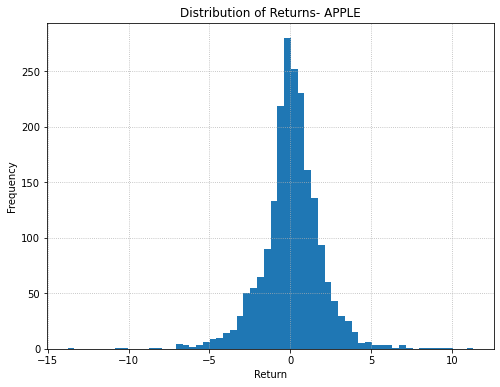

In [7]:
# Plotting the returns
plt.figure(figsize=(8, 6))
plt.hist(df['return'], bins=60)
plt.title('Distribution of Returns- APPLE')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.grid(linestyle=':');

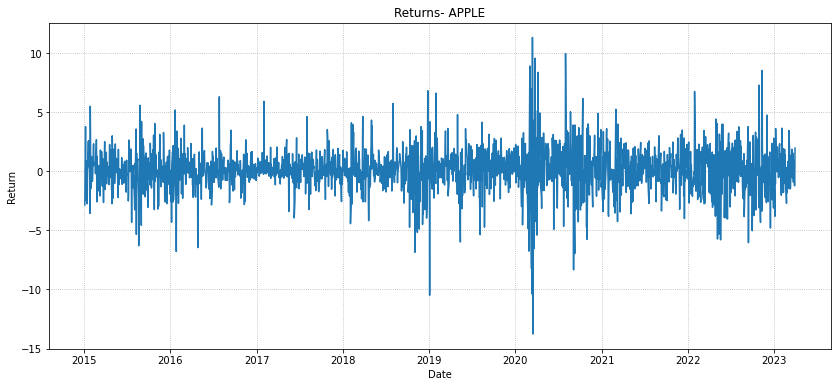

In [8]:
# Plotting the returns with respect to time
plt.figure(figsize=(14, 6))
plt.plot(df['return'])
plt.title('Returns- APPLE')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(linestyle=':');

In [9]:
# Testing the normal distribution of the returns
skewness = np.mean(df['return'] - np.mean(df['return'])) / np.std(df['return'])
kurtosis = np.mean((df['return'] - np.mean(df['return'])) ** 4) / np.mean((df['return'] - np.mean(df['return']))**2)**2 - 3
jb_test = jarque_bera(df['return'])
p_value = jb_test[1]
norm_test = normaltest(df['return'])
p_value = norm_test[1]
print('Jarque-Bera test p-value: ', jb_test[1])
print('Normality test p-value: ', norm_test[1])

Jarque-Bera test p-value:  0.0
Normality test p-value:  8.350991414913826e-57


In [10]:
# Calculating the realized volatility and dropping NA values and unnecessary columns
df['realized_vol'] = df['return'].rolling(5).std()*sqrt(5) # 5-days realized volatility
df.drop(columns=['Open', 'High', 'Low', 'Close'], inplace=True)
df.dropna(inplace=True)

In [11]:
# Checking the data
df.tail()

,Adj Close,Volume,return,realized_vol
Date,,,,
2023-03-23,158.929993,67622100,0.694529,2.403773
2023-03-24,160.250000,59196500,0.827129,2.107840
2023-03-27,158.279999,52390300,-1.236949,2.469941
2023-03-28,157.649994,45992200,-0.398826,2.085766
2023-03-29,160.770004,51305700,1.959745,2.742022


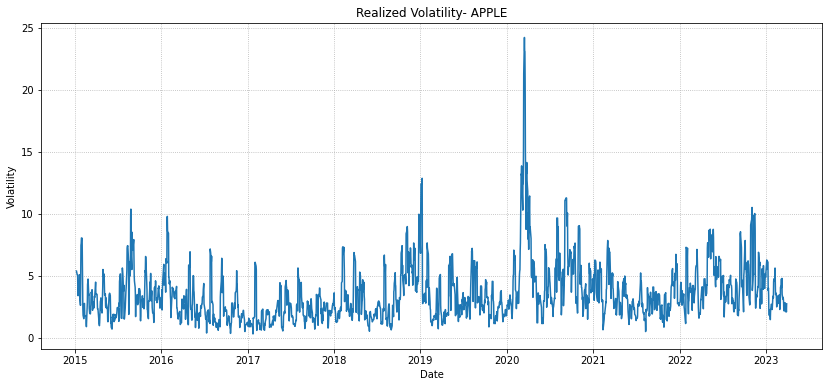

In [12]:
# Plotting the realized volatility
plt.figure(figsize=(14, 6))
plt.plot(df['realized_vol'])
plt.title('Realized Volatility- APPLE')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(linestyle=':');

## 3. ARCH Variations

### 3.1. ARCH Model
The ARCH (Autoregressive Conditional Heteroscedasticity) model is a statistical model commonly used in finance to model time-varying volatility in asset prices. The model assumes that the variance of an asset's returns is not constant over time, but rather varies based on past returns.

The ARCH model is based on the idea that volatility clusters, meaning that periods of high volatility tend to be followed by further periods of high volatility, and periods of low volatility tend to be followed by further periods of low volatility. The model uses past observations of asset returns to estimate the variance of returns in the future.

The basic ARCH model is a univariate time series model that assumes that the conditional variance of an asset's returns at time t is a function of the variance of past returns. 

In [13]:
# Defining the split and assigning the split data
n = 252
split_date = df['return'].iloc[-n:].index 
split_date

DatetimeIndex(['2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01',
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11',
               ...
               '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27',
               '2023-03-28', '2023-03-29'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

In [14]:
# Built-in function for ARCH modelling
arch = arch_model(df['return'], mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4170.15
Distribution:                  Normal   AIC:                           8344.30
Method:            Maximum Likelihood   BIC:                           8355.57
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:16   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.7346      0.193     14.182  1.189e-45 [  2.357,  3.11

In [15]:
# Tuning the ARCH model with respect to lag parameter
bic_arch = []
for p in range(1, 22): 
    arch = arch_model(df['return'], mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch): 
        best_param = p
best_param # Extracting the best number of lags

8

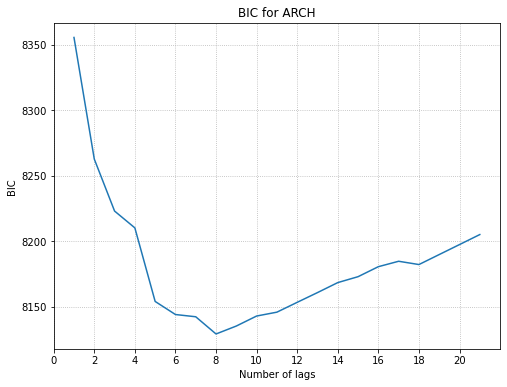

In [16]:
# Plotting the Bayesian Information Criterion for the ARCH model w.r.t. lag
plt.figure(figsize=(8, 6))
plt.plot(range(1, 22), bic_arch)
plt.title('BIC for ARCH')
plt.ylabel('BIC')
plt.xlabel('Number of lags')
plt.xticks(range(0, 21, 2)) 
plt.grid(linestyle=':');

In [17]:
# Building the model based on the best lag
arch = arch_model(df['return'], mean='zero', vol='ARCH', p=best_param).fit(disp='off') 
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4030.24
Distribution:                  Normal   AIC:                           8078.47
Method:            Maximum Likelihood   BIC:                           8129.19
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:20   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.1198      0.180      6.232  4.596e-10 

In [18]:
# Forecast performance measurements
forecast = arch.forecast(start=split_date[0]) # Forecasting based on ARCH
forecast_arch = forecast
rmse_arch = np.sqrt(mse(df.loc[split_date,'realized_vol']/100,
                     np.sqrt(forecast_arch.variance.iloc[-len(split_date):]/100))) # Testing the accuracy of the ARCH model
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1626


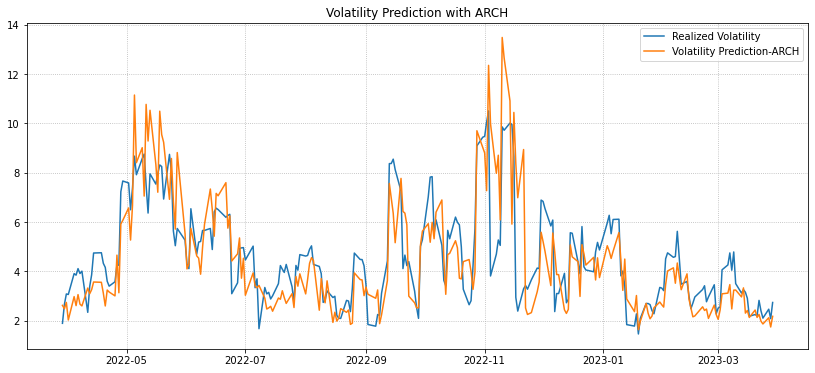

In [19]:
# Plotting the predicted values vs. the actual values
plt.figure(figsize=(14, 6))
plt.plot(df.loc[split_date,'realized_vol'], label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):], label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH')
plt.legend()
plt.grid(linestyle=':');

In [20]:
# Calculate the number of steps that the direction of the movement was the same as the direction of the prediction
df_forecast = pd.concat([forecast_arch.variance.iloc[-len(split_date):],df['realized_vol'].iloc[-len(split_date):]],axis=1)
df_forecast['real_vol_lag'] = df_forecast['realized_vol'].shift(1) # One lag of the realized volatility
df_forecast['real_vol_diff'] = df_forecast['realized_vol'].diff(1) # Difference between realized vol. and its lag
df_forecast['rv_h.1_diff'] = df_forecast['h.1'] - df_forecast['real_vol_lag'] # Difference between prediction and actual val
df_forecast['sign'] = df_forecast['real_vol_diff'] * df_forecast['rv_h.1_diff'] # Determining the sign of the direction
df_forecast['sign'] = (df_forecast['sign'] > 0).astype(int) # If sign>0, the directions were the same
df_forecast.head(10)

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff,sign
Date,,,,,,
2022-03-29,2.625162,1.897386,NaN,NaN,NaN,0
2022-03-30,2.486795,2.664645,1.897386,0.767259,0.589409,1
2022-03-31,2.744364,3.087585,2.664645,0.422940,0.079719,1
2022-04-01,2.032233,3.067032,3.087585,-0.020553,-1.055352,1
2022-04-04,2.979718,3.913564,3.067032,0.846532,-0.087314,0
2022-04-05,2.614836,3.850545,3.913564,-0.063020,-1.298728,1
2022-04-06,3.061303,4.114822,3.850545,0.264278,-0.789241,0
2022-04-07,2.673823,3.915517,4.114822,-0.199305,-1.440999,1
2022-04-08,2.602882,4.011772,3.915517,0.096255,-1.312635,0


In [21]:
# Number of steps that the signs were the same and opposite (1:= The same direction of prediction and actual value)
signs_arch = df_forecast['sign']
sign_arch = df_forecast['sign'].value_counts(normalize=False) 
sign_arch # Normalize=True gives the percentage

1    157
0     95
Name: sign, dtype: int64

In [22]:
"""The sum of the absolute values of the 'real_vol_diff' column is the amount of Profit/Loss that we will have after
each prediction. If the value of the 'sign' is equal to 1, it means that the direction of the prediction and the movement
is the same, thus, we will have a profit as much as the actual movement in the value of the Implied Volatility.
On the other hand, if the 'sign' is equal to 0, it means that the direction of the prediction and the actual movement are
opposite, thus, we will have a loss as much as the actual movement in the value of the Implied Volatility."""
pl_arch = df_forecast.abs().groupby('sign')['real_vol_diff'].sum() # Total Gain/Loss from transaction based on prediction
df_forecast.abs().groupby('sign').sum() 

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff
sign,,,,,
0,438.663198,471.425126,455.985013,36.666243,68.260233
1,678.522886,684.850495,697.548585,147.938789,197.600082


### 3.2. GARCH Model
GARCH (Generalized Autoregressive Conditional Heteroscedasticity) is a statistical model used in finance to model the volatility of asset prices over time. It is an extension of the ARCH model.

The GARCH model is similar to the ARCH model in that it assumes that the conditional variance of an asset's returns is not constant over time, but varies based on past returns. However, the GARCH model allows for a more flexible specification of the variance dynamics by including lagged values of both the squared error term and the conditional variance term in the model equation.

In [23]:
# Built-in funtion for GARCH modelling
garch = arch_model(df['return'], mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4030.83
Distribution:                  Normal   AIC:                           8067.67
Method:            Maximum Likelihood   BIC:                           8084.57
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:20   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1512  4.854e-02      3.115  1.841e-03 [5.605e-0

In [24]:
# Tuning the GARCH model with respect to lag parameters of p and q
bic_garch = []
for p in range(1, 11):
    for q in range(1, 11):
        garch = arch_model(df['return'], mean='zero',vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
best_param

(1, 1)

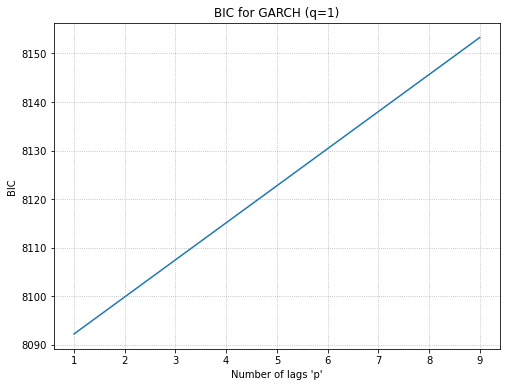

In [25]:
# Plotting the Bayesian Information Criterion for the GARCH model w.r.t. lag p
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), bic_garch[1:10])
plt.title('BIC for GARCH (q=1)')
plt.ylabel('BIC')
plt.xlabel("Number of lags 'p'")
plt.grid(linestyle=':');

In [26]:
# Building the model based on the best lag
garch = arch_model(df['return'], mean='zero', vol='GARCH', p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4030.83
Distribution:                  Normal   AIC:                           8067.67
Method:            Maximum Likelihood   BIC:                           8084.57
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:33   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1512  4.854e-02      3.115  1.841e-03 [5.605e-0

In [27]:
# Forecast performance measurements
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast
rmse_garch = np.sqrt(mse(df.loc[split_date,'realized_vol']/100,
                np.sqrt(forecast_garch.variance.iloc[-len(split_date):]/100))) # Testing the accuracy of the GARCH model
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.1617


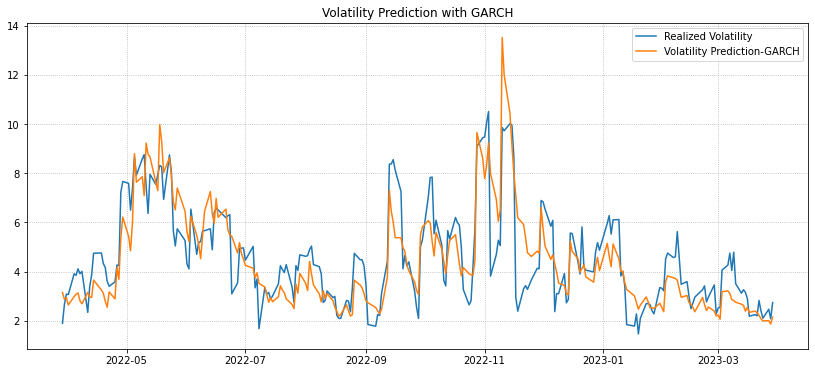

In [28]:
# Plotting the predicted values vs. the actual values
plt.figure(figsize=(14, 6))
plt.plot(df.loc[split_date,'realized_vol'], label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):], label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH')
plt.legend()
plt.grid(linestyle=':');

In [29]:
# Calculate the number of steps that the direction of the movement was the same as the direction of the prediction
df_forecast = pd.concat([forecast_garch.variance.iloc[-len(split_date):],df['realized_vol'].iloc[-len(split_date):]],axis=1)
df_forecast['real_vol_lag'] = df_forecast['realized_vol'].shift(1) # One lag of the realized volatility
df_forecast['real_vol_diff'] = df_forecast['realized_vol'].diff(1) # Difference between realized vol. and its lag
df_forecast['rv_h.1_diff'] = df_forecast['h.1'] - df_forecast['real_vol_lag'] # Difference between prediction and actual val
df_forecast['sign'] = df_forecast['real_vol_diff'] * df_forecast['rv_h.1_diff'] # Determining the sign of the direction
df_forecast['sign'] = (df_forecast['sign'] > 0).astype(int) # If sign>0, the directions were the same
df_forecast.head(10)

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff,sign
Date,,,,,,
2022-03-29,3.153541,1.897386,NaN,NaN,NaN,0
2022-03-30,2.873488,2.664645,1.897386,0.767259,0.976102,1
2022-03-31,2.935334,3.087585,2.664645,0.422940,0.270690,1
2022-04-01,2.643570,3.067032,3.087585,-0.020553,-0.444015,1
2022-04-04,2.985154,3.913564,3.067032,0.846532,-0.081878,0
2022-04-05,3.077573,3.850545,3.913564,-0.063020,-0.835992,1
2022-04-06,3.135537,4.114822,3.850545,0.264278,-0.715008,0
2022-04-07,2.813658,3.915517,4.114822,-0.199305,-1.301164,1
2022-04-08,2.692198,4.011772,3.915517,0.096255,-1.223319,0


In [30]:
# Number of steps that the signs were the same and opposite (1:= The same direction of prediction and actual value)
signs_garch = df_forecast['sign']
sign_garch = df_forecast['sign'].value_counts(normalize=False) 
sign_garch

1    166
0     86
Name: sign, dtype: int64

In [31]:
"""The sum of the absolute values of the 'real_vol_diff' column is the amount of Profit/Loss that we will have after
each prediction. If the value of the 'sign' is equal to 1, it means that the direction of the prediction and the movement
is the same, thus, we will have a profit as much as the actual movement in the value of the Implied Volatility.
On the other hand, if the 'sign' is equal to 0, it means that the direction of the prediction and the actual movement are
opposite, thus, we will have a loss as much as the actual movement in the value of the Implied Volatility."""
pl_garch = df_forecast.abs().groupby('sign')['real_vol_diff'].sum() # Total Gain/Loss from transaction based on prediction
df_forecast.abs().groupby('sign').sum() 

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff
sign,,,,,
0,387.128545,417.429794,406.623802,29.012970,60.829318
1,720.273466,738.845827,746.909797,155.592062,187.616459


### 3.3. GJR-GARCH Model
GJR-GARCH (Glosten-Jagannathan-Runkle Generalized Autoregressive Conditional Heteroskedasticity) is an extension of the GARCH model. The GJR-GARCH model differs from the GARCH model by incorporating a leverage effect in the variance equation. The leverage effect allows for the possibility that negative shocks have a greater impact on volatility than positive shocks of the same magnitude.

The GJR-GARCH model specifies the conditional variance of an asset's returns as a function of past returns and past conditional variances, as well as a leverage effect term. The model allows for asymmetric effects of positive and negative shocks on future volatility. Specifically, it assumes that a negative shock has a greater impact on future volatility than an equally sized positive shock.

In [32]:
# Built-in funtion for GJR-GARCH modelling
gjrgarch = arch_model(df['return'], mean='zero', p=1, o=1, q=1).fit(disp='off')
print(gjrgarch.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4001.43
Distribution:                  Normal   AIC:                           8010.87
Method:            Maximum Likelihood   BIC:                           8033.41
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:33   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1560  4.180e-02      3.733  1.893e-04 

In [33]:
# Tuning the GJR-GARCH model with respect to lag parameters of p, o, and q
bic_gjrgarch = []
for p in range(1, 11):
    for o in range(0, 5):
        for q in range(1, 11):
            gjrgarch = arch_model(df['return'], mean='zero',vol='GARCH', p=p, o=o, q=q).fit(disp='off')
            bic_gjrgarch.append(gjrgarch.bic)
            if gjrgarch.bic == np.min(bic_gjrgarch):
                best_param = p, o, q
best_param

(1, 1, 1)

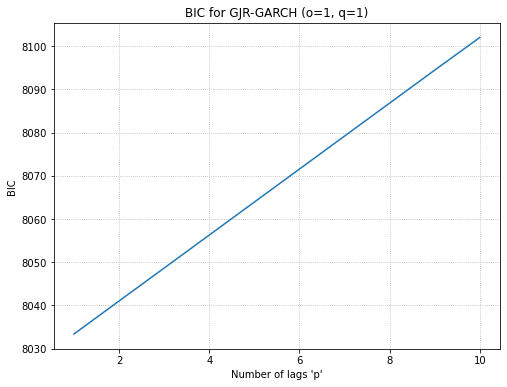

In [34]:
# Plotting the Bayesian Information Criterion for the GJR-GARCH model w.r.t. lag p
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), bic_gjrgarch[10:20])
plt.title('BIC for GJR-GARCH (o=1, q=1)')
plt.ylabel('BIC')
plt.xlabel("Number of lags 'p'")
plt.grid(linestyle=':');

In [35]:
# Building the model based on the best lag
gjrgarch = arch_model(df['return'], mean='zero', vol='GARCH', p=best_param[0], o=best_param[1], q=best_param[2]).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4030.83
Distribution:                  Normal   AIC:                           8067.67
Method:            Maximum Likelihood   BIC:                           8084.57
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:33   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1512  4.854e-02      3.115  1.841e-03 [5.605e-0

In [36]:
# Forecast performance measurements
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast
rmse_gjrgarch = np.sqrt(mse(df.loc[split_date,'realized_vol']/100,
                np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):]/100))) # Testing the accuracy of the GJR-GARCH model
print('The RMSE value of GJR-GARCH model is {:.4f}'.format(rmse_gjrgarch))

The RMSE value of GJR-GARCH model is 0.1697


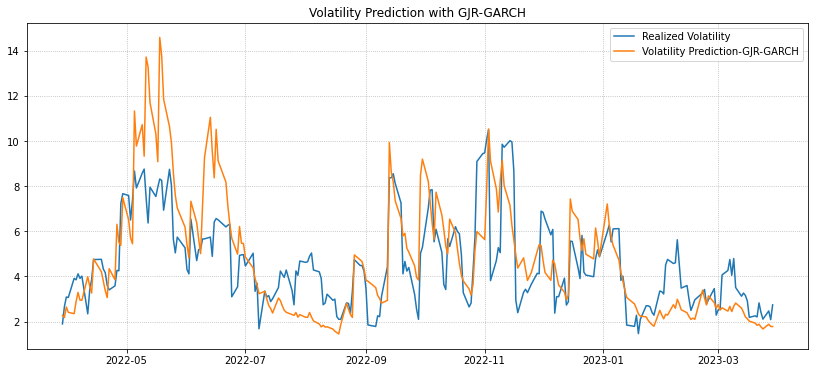

In [37]:
# Plotting the predicted values vs. the actual values
plt.figure(figsize=(14, 6))
plt.plot(df.loc[split_date,'realized_vol'], label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):], label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH')
plt.legend()
plt.grid(linestyle=':');

In [38]:
# Calculate the number of steps that the direction of the movement was the same as the direction of the prediction
df_forecast = pd.concat([forecast_gjrgarch.variance.iloc[-len(split_date):],df['realized_vol'].iloc[-len(split_date):]],axis=1)
df_forecast['real_vol_lag'] = df_forecast['realized_vol'].shift(1) # One lag of the realized volatility
df_forecast['real_vol_diff'] = df_forecast['realized_vol'].diff(1) # Difference between realized vol. and its lag
df_forecast['rv_h.1_diff'] = df_forecast['h.1'] - df_forecast['real_vol_lag'] # Difference between prediction and actual val
df_forecast['sign'] = df_forecast['real_vol_diff'] * df_forecast['rv_h.1_diff'] # Determining the sign of the direction
df_forecast['sign'] = (df_forecast['sign'] > 0).astype(int) # If sign>0, the directions were the same
df_forecast.head(10)

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff,sign
Date,,,,,,
2022-03-29,2.278547,1.897386,NaN,NaN,NaN,0
2022-03-30,2.178577,2.664645,1.897386,0.767259,0.281191,1
2022-03-31,2.646309,3.087585,2.664645,0.422940,-0.018335,0
2022-04-01,2.407853,3.067032,3.087585,-0.020553,-0.679732,1
2022-04-04,2.350491,3.913564,3.067032,0.846532,-0.716542,0
2022-04-05,2.879980,3.850545,3.913564,-0.063020,-1.033584,1
2022-04-06,3.291682,4.114822,3.850545,0.264278,-0.558862,0
2022-04-07,2.950577,3.915517,4.114822,-0.199305,-1.164246,1
2022-04-08,2.946328,4.011772,3.915517,0.096255,-0.969190,0


In [39]:
# Number of steps that the signs were the same and opposite (1:= The same direction of prediction and actual value)
signs_gjrgarch = df_forecast['sign']
sign_gjrgarch = df_forecast['sign'].value_counts(normalize=False) 
sign_gjrgarch

1    157
0     95
Name: sign, dtype: int64

In [40]:
"""The sum of the absolute values of the 'real_vol_diff' column is the amount of Profit/Loss that we will have after
each prediction. If the value of the 'sign' is equal to 1, it means that the direction of the prediction and the movement
is the same, thus, we will have a profit as much as the actual movement in the value of the Implied Volatility.
On the other hand, if the 'sign' is equal to 0, it means that the direction of the prediction and the actual movement are
opposite, thus, we will have a loss as much as the actual movement in the value of the Implied Volatility."""
pl_gjrgarch = df_forecast.abs().groupby('sign')['real_vol_diff'].sum() # Total Gain/Loss from transaction based on prediction
df_forecast.abs().groupby('sign').sum() 

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff
sign,,,,,
0,444.524643,432.008195,433.837617,43.236876,113.206878
1,747.392221,724.267425,719.695982,141.368156,238.504525


### EGARCH Model
EGARCH (Exponential Generalized Autoregressive Conditional Heteroscedasticity) is a statistical model used in to model the volatility of asset prices over time. It is an extension of the GARCH model.

The EGARCH model is similar to the GARCH model in that it assumes that the conditional variance of an asset's returns is not constant over time, but varies based on past returns. However, the EGARCH model allows for a more flexible specification of the variance dynamics by including the logarithm of the conditional variance term in the model equation. The logarithmic transformation allows for both positive and negative shocks to have asymmetric effects on volatility. Specifically, the EGARCH model allows for leverage effects, where negative shocks have a larger impact on volatility than positive shocks of the same magnitude.

In [41]:
# Built-in funtion for EGARCH modelling
egarch = arch_model(df['return'], mean='zero', vol='EGARCH', p=1, q=1).fit(disp='off')
print(egarch.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4034.83
Distribution:                  Normal   AIC:                           8075.65
Method:            Maximum Likelihood   BIC:                           8092.55
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:03:57   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0592  2.099e-02      2.819  4.818e-03 [1.803e-0

In [42]:
# Tuning the EGARCH model with respect to lag parameters of p and q
bic_egarch = []
for p in range(1, 11):
    for q in range(1, 11):
        egarch = arch_model(df['return'], mean='zero',vol='EGARCH', p=p, o=0, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
best_param

(1, 1)

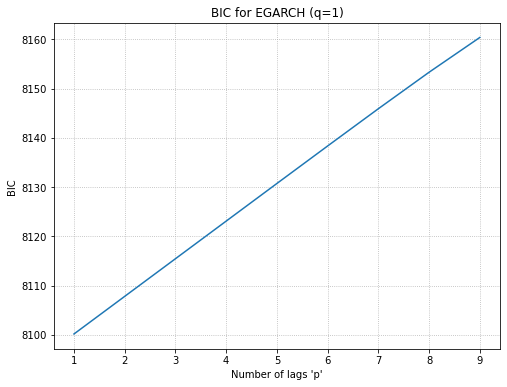

In [43]:
# Plotting the Bayesian Information Criterion for the GARCH model w.r.t. lag p
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), bic_egarch[1:10])
plt.title('BIC for EGARCH (q=1)')
plt.ylabel('BIC')
plt.xlabel("Number of lags 'p'")
plt.grid(linestyle=':');

In [44]:
# Building the model based on the best lag
egarch = arch_model(df['return'], mean='zero', vol='EGARCH', p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4030.83
Distribution:                  Normal   AIC:                           8067.67
Method:            Maximum Likelihood   BIC:                           8084.57
                                        No. Observations:                 2069
Date:                Mon, Apr 10 2023   Df Residuals:                     2069
Time:                        18:02:33   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1512  4.854e-02      3.115  1.841e-03 [5.605e-0

In [45]:
# Forecast performance measurements
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast
rmse_egarch = np.sqrt(mse(df.loc[split_date,'realized_vol']/100,
                np.sqrt(forecast_egarch.variance.iloc[-len(split_date):]/100))) # Testing the accuracy of the EGARCH model
print('The RMSE value of EGARCH model is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH model is 0.1636


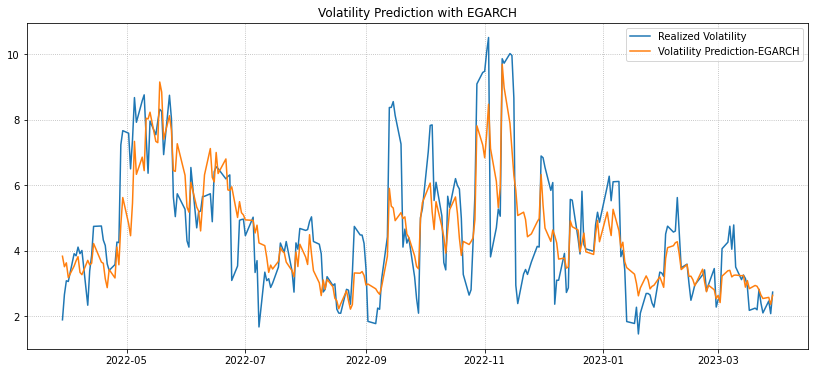

In [46]:
# Plotting the predicted values vs. the actual values
plt.figure(figsize=(14, 6))
plt.plot(df.loc[split_date,'realized_vol'], label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):], label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH')
plt.legend()
plt.grid(linestyle=':');

In [47]:
# Calculate the number of steps that the direction of the movement was the same as the direction of the prediction
df_forecast= pd.concat([forecast_egarch.variance.iloc[-len(split_date):],df['realized_vol'].iloc[-len(split_date):]],axis=1)
df_forecast['real_vol_lag'] = df_forecast['realized_vol'].shift(1) # One lag of the realized volatility
df_forecast['real_vol_diff'] = df_forecast['realized_vol'].diff(1) # Difference between realized vol. and its lag
df_forecast['rv_h.1_diff'] = df_forecast['h.1'] - df_forecast['real_vol_lag'] # Difference between prediction and actual val
df_forecast['sign'] = df_forecast['real_vol_diff'] * df_forecast['rv_h.1_diff'] # Determining the sign of the direction
df_forecast['sign'] = (df_forecast['sign'] > 0).astype(int) # If sign>0, the directions were the same
df_forecast.head(10)

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff,sign
Date,,,,,,
2022-03-29,3.836359,1.897386,NaN,NaN,NaN,0
2022-03-30,3.516844,2.664645,1.897386,0.767259,1.619459,1
2022-03-31,3.635396,3.087585,2.664645,0.422940,0.970751,1
2022-04-01,3.186350,3.067032,3.087585,-0.020553,0.098765,0
2022-04-04,3.537857,3.913564,3.067032,0.846532,0.470825,1
2022-04-05,3.698015,3.850545,3.913564,-0.063020,-0.215549,1
2022-04-06,3.822807,4.114822,3.850545,0.264278,-0.027738,0
2022-04-07,3.344384,3.915517,4.114822,-0.199305,-0.770438,1
2022-04-08,3.273288,4.011772,3.915517,0.096255,-0.642229,0


In [48]:
# Number of steps that the signs were the same and opposite (1:= The same direction of prediction and actual value)
signs_egarch = df_forecast['sign']
sign_egarch = df_forecast['sign'].value_counts(normalize=False) 
sign_egarch

1    174
0     78
Name: sign, dtype: int64

In [49]:
"""The sum of the absolute values of the 'real_vol_diff' column is the amount of Profit/Loss that we will have after
each prediction. If the value of the 'sign' is equal to 1, it means that the direction of the prediction and the movement
is the same, thus, we will have a profit as much as the actual movement in the value of the Implied Volatility.
On the other hand, if the 'sign' is equal to 0, it means that the direction of the prediction and the actual movement are
opposite, thus, we will have a loss as much as the actual movement in the value of the Implied Volatility."""
pl_egarch = df_forecast.abs().groupby('sign')['real_vol_diff'].sum() # Total Gain/Loss from transaction based on prediction
df_forecast.abs().groupby('sign').sum() 

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff
sign,,,,,
0,356.840173,377.399648,373.983388,29.534186,58.761631
1,764.774572,778.875973,779.550210,155.070846,181.353591


### Comparison of the ARCH variation Models

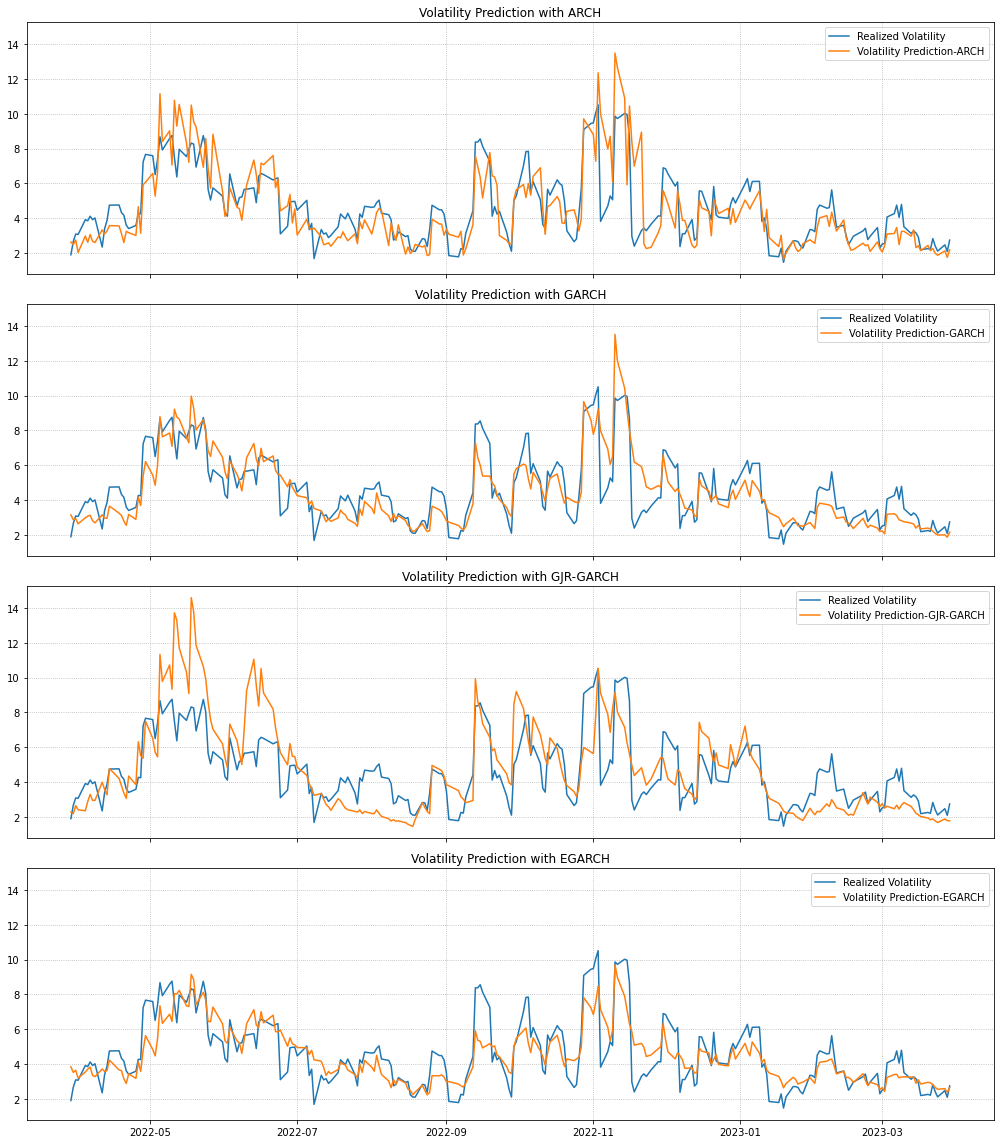

In [50]:
# Plotting all of the models predictions vs. the actual values
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True, sharey=True)

axs[0].plot(df.loc[split_date, 'realized_vol'], label='Realized Volatility')
axs[0].plot(forecast_arch.variance.iloc[-len(split_date):], label='Volatility Prediction-ARCH')
axs[0].set_title('Volatility Prediction with ARCH')
axs[0].legend()
axs[0].grid(linestyle=':')

axs[1].plot(df.loc[split_date, 'realized_vol'], label='Realized Volatility')
axs[1].plot(forecast_garch.variance.iloc[-len(split_date):], label='Volatility Prediction-GARCH')
axs[1].set_title('Volatility Prediction with GARCH')
axs[1].legend()
axs[1].grid(linestyle=':')

axs[2].plot(df.loc[split_date, 'realized_vol'], label='Realized Volatility')
axs[2].plot(forecast_gjrgarch.variance.iloc[-len(split_date):], label='Volatility Prediction-GJR-GARCH')
axs[2].set_title('Volatility Prediction with GJR-GARCH')
axs[2].legend()
axs[2].grid(linestyle=':')

axs[3].plot(df.loc[split_date, 'realized_vol'], label='Realized Volatility')
axs[3].plot(forecast_egarch.variance.iloc[-len(split_date):], label='Volatility Prediction-EGARCH')
axs[3].set_title('Volatility Prediction with EGARCH')
axs[3].legend()
axs[3].grid(linestyle=':')

plt.tight_layout()
plt.show()


In [51]:
# Comparing the values of sign
# 'sign=1' means that the model's prediction is in the same direction of the actual value for the next step
# 'sign=0' means vice versa
sign_models = pd.DataFrame([sign_arch, sign_garch, sign_gjrgarch, sign_egarch]).T # Create a dataframe of the values
sign_models.columns = ['ARCH', 'GARCH', 'GJR-GARCH', 'EGARCH']
sign_models

,ARCH,GARCH,GJR-GARCH,EGARCH
1,157,166,157,174
0,95,86,95,78


In [52]:
# Convert the dataframe to percentage(probability)
col_sum = sign_models.sum()
proportions_df = sign_models.div(col_sum, axis=1)
round(proportions_df*100, 2)

,ARCH,GARCH,GJR-GARCH,EGARCH
1,62.3,65.87,62.3,69.05
0,37.7,34.13,37.7,30.95


In [53]:
# Comparing the values of sign with respect to the absolute Gain/Loss from  prediction
# 'sign=1' means that the model's prediction is in the same direction of the actual value for the next step
# 'sign=0' means vice versa
pl_models = pd.DataFrame([pl_arch, pl_garch, pl_gjrgarch, pl_egarch]).T # Create a dataframe of the values
pl_models.columns = ['ARCH', 'GARCH', 'GJR-GARCH', 'EGARCH']
pl_models

,ARCH,GARCH,GJR-GARCH,EGARCH
sign,,,,
0,36.666243,29.012970,43.236876,29.534186
1,147.938789,155.592062,141.368156,155.070846


In [57]:
# Collecting all the signs from differenct ARCH  variations
all_signs = pd.DataFrame([signs_arch, signs_garch, signs_gjrgarch, signs_egarch]).T # Create a dataframe of the values
all_signs.columns = ['ARCH', 'GARCH', 'GJR-GARCH', 'EGARCH']
all_signs['sum_signs'] = all_signs['ARCH'] + all_signs['GARCH'] + all_signs['GJR-GARCH'] + all_signs['EGARCH']
all_signs.head()

,ARCH,GARCH,GJR-GARCH,EGARCH,sum_signs
Date,,,,,
2022-03-29,0,0,0,0,0
2022-03-30,1,1,1,1,4
2022-03-31,1,1,0,1,3
2022-04-01,1,1,1,0,3
2022-04-04,0,0,0,1,1


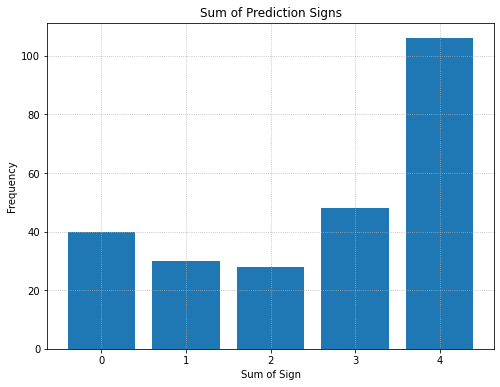

In [75]:
# Plotting the sum of signs of model predictions
counts = all_signs['sum_signs'].value_counts().to_dict() # Get the counts of unique values in 'sum_signs'
plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values())
plt.title('Sum of Prediction Signs')
plt.ylabel('Frequency')
plt.xlabel('Sum of Signs')
plt.xticks(list(counts.keys())) # set the x-axis tick values to be the same as the bar positions
plt.grid(linestyle=':');